# TestCase3 - Convergence FEM / PINNs+Corr

In [1]:
from create_jsonfile import ask_user,read_config

# ask_user()
config = read_config()

### Configuration has been read from config.json ###
# dimension : 1
# testcase : 1
# version : 2
# param_num : 4


In [2]:
dimension = config["dimension"]
testcase = config["testcase"]
version = config["version"]
if dimension == 2 and testcase == 3:
    largenet = False
    if "largenet" in version:
        largenet = True
    version = "medium"
param_num = config["param_num"]        

In [3]:
high_degree = 10

## Imports + Load

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df
import seaborn as sns
import dataframe_image as dfi

# from modfenics.fenics_expressions.fenics_expressions_2D import UexExpr
from scimba.equations.domain import SpaceTensor
from scimba.equations import domain

from testcases.utils import create_tree
# from modfenics.fenics_expressions.fenics_expressions import FExpr,AnisotropyExpr
# from modfenics.utils import get_param,compute_slope
from modfenics.error_estimations.fem import compute_error_estimations_fem_deg,compute_error_estimations_fem_all
from modfenics.error_estimations.add import compute_error_estimations_Corr_deg,compute_error_estimations_Corr_all
from modfenics.error_estimations.mult import compute_error_estimations_Mult_deg,compute_error_estimations_Mult_all
from modfenics.error_estimations.compare import plot_Corr_vs_FEM,plot_Mult_vs_FEM,plot_Mult_vs_Add_vs_FEM,save_tab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Using device: cpu


/home/flecourtier/anaconda3/envs/fenics_scimba_modules/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400441250/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
assert dimension in [1,2]
if dimension == 1:
    result_dir = "../../../results/fenics/test_1D/testcase"+str(testcase)+"/version"+str(version)
    if testcase == 1:
        if version == 1:
            from testcases.networks.test_1D.test_1.test_1_v1 import Run_laplacian1D,Poisson_1D
        elif version == 2:
            from testcases.networks.test_1D.test_1.test_1_v2 import Run_laplacian1D,Poisson_1D
        else:
            raise ValueError("Version not found")
        from testcases.problem.problem_1D import TestCase1
        problem = TestCase1(version=version)
    elif testcase == 2:
        if version == 1:
            from testcases.networks.test_1D.test_2.test_2_v1 import Run_laplacian1D,Poisson_1D
        elif version == 2:
            from testcases.networks.test_1D.test_2.test_2_v2 import Run_laplacian1D,Poisson_1D
        else:
            raise ValueError("Version not found")
        from testcases.problem.problem_1D import TestCase2
        problem = TestCase2(version=version)
elif dimension == 2:
    result_dir = "../../../results/fenics/test_2D/testcase"+str(testcase)+"/version"+str(version)
    if testcase == 1:
        if version == 1:
            from testcases.networks.test_2D.test_1.test_1_v1 import Run_laplacian2D,Poisson_2D
        elif version == 2:
            from testcases.networks.test_2D.test_1.test_1_v2 import Run_laplacian2D,Poisson_2D
        else:
            raise ValueError("Version not found")
        from testcases.problem.problem_2D import TestCase1
        problem = TestCase1(version=version)
    elif testcase == 2:
        from testcases.networks.test_2D.test_2.test_2_v1 import Run_laplacian2D,Poisson_2D
        from testcases.problem.problem_2D import TestCase2
        problem = TestCase2(version=version)
    elif testcase == 3:
        if version != "new":
            from testcases.networks.test_2D.test_3.test_3_v1 import Run_laplacian2D,Poisson_2D
        else:
            from testcases.networks.test_2D.test_3.test_3_v2 import Run_laplacian2D,Poisson_2D
        from testcases.problem.problem_2D import TestCase3
        problem = TestCase3(version=version)
        result_dir = "../../../results/fenics/test_2D/testcase"+str(testcase)+"/"+version
        if version == "medium" and largenet:
            result_dir += "_largenet"
    elif testcase == 4:
        from testcases.networks.test_2D.test_4.test_4_v1 import Run_laplacian2D,Poisson_2D
        from testcases.problem.problem_2D import TestCase4
        problem = TestCase4(v=version)

result_dir += "/cvg/"
create_tree(result_dir)
    # elif testcase == 4:

/home/flecourtier/Bureau/Article1/code
torch loaded; device is cpu


init
Training PINN
init
>> load network /home/flecourtier/Bureau/Article1/code/networks/test_1D/test_fe1_v2.pth
network loaded
Error  tensor([0.0047])


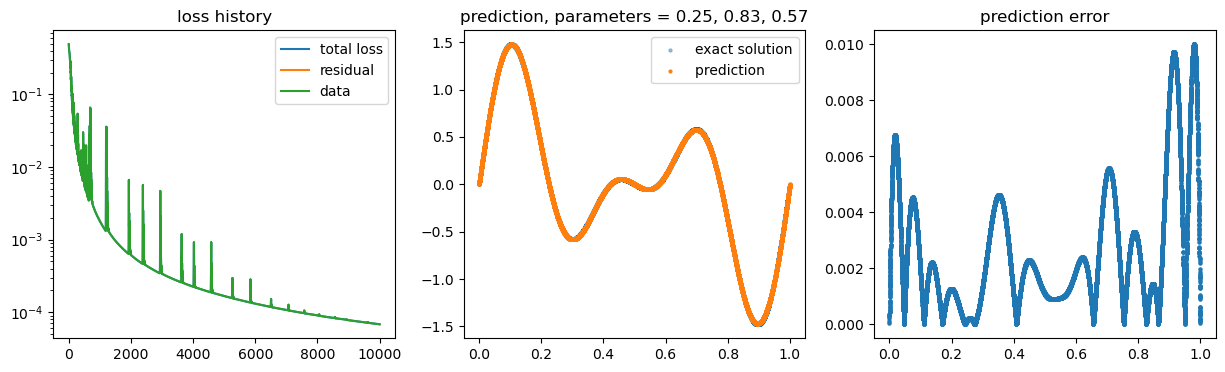

In [7]:
if dimension == 1:
    pde = Poisson_1D()
    trainer,u_theta = Run_laplacian1D(pde)
elif dimension == 2:
    if testcase == 3 and version != "new":
        pde = Poisson_2D(version)
        trainer,u_theta = Run_laplacian2D(pde,version,largenet)
    else:
        pde = Poisson_2D()
        trainer,u_theta = Run_laplacian2D(pde)

## Convergence FEM

In [8]:
degree = 1
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = compute_error_estimations_fem_deg(param_num,problem,degree,high_degree,new_run=False,result_dir=result_dir)

## Run error estimation with FEM for degree=1
V_ex created with  501  vertices and degree  4  : h_ex = 0.0020000000000000018
Mesh created with  16  vertices : h = 0.06666666666666676
feeeeeeeeeemmmm
nb_vert=16, norme_L2=0.09421320739468109
Mesh created with  32  vertices : h = 0.032258064516129115
feeeeeeeeeemmmm
nb_vert=32, norme_L2=0.02262744375352155
Mesh created with  64  vertices : h = 0.015873015873015928
feeeeeeeeeemmmm
nb_vert=64, norme_L2=0.005515528011798697
Mesh created with  128  vertices : h = 0.007874015748031593
feeeeeeeeeemmmm
nb_vert=128, norme_L2=0.0013615879173442293
Mesh created with  256  vertices : h = 0.0039215686274510775
feeeeeeeeeemmmm
nb_vert=256, norme_L2=0.0003428911404048643


In [9]:
# compute_error_estimations_fem_all(param_num,problem,high_degree,new_run=True,result_dir=result_dir,plot_cvg=True)

## Convergence PINNs+Corr

In [10]:
degree = 1
df_Corr, tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = compute_error_estimations_Corr_deg(param_num,problem,degree,high_degree,u_theta,new_run=False,result_dir=result_dir)

## Run error estimation with Corr (add) for degree=1
V_ex created with  501  vertices and degree  4  : h_ex = 0.0020000000000000018
Mesh created with  16  vertices : h = 0.06666666666666676
nb_vert=16, norme_L2=0.002280893173391858
Mesh created with  32  vertices : h = 0.032258064516129115
nb_vert=32, norme_L2=0.0007494514779061854
Mesh created with  64  vertices : h = 0.015873015873015928
nb_vert=64, norme_L2=0.00020878121998601444
Mesh created with  128  vertices : h = 0.007874015748031593
nb_vert=128, norme_L2=5.311209678625807e-05
Mesh created with  256  vertices : h = 0.0039215686274510775
nb_vert=256, norme_L2=1.3384974017752174e-05


In [11]:
# compute_error_estimations_Corr_all(param_num,problem,high_degree,u_theta,new_run=True,result_dir=result_dir,plot_cvg=True)

### Plots FEM-Corr

In [12]:
# plot_Corr_vs_FEM(param_num,problem,result_dir=result_dir)

## Convergence PINNs+Mult

In [13]:
degree = 1
# tab_M = [0.0,0.1,1.0,100.0]
tab_M = [3.0,100.0]

for M in tab_M:
    print("#### M = ",M)
    df_Mult, tab_nb_vert_Mult, tab_h_Mult, tab_err_Mult = compute_error_estimations_Mult_deg(param_num,problem,degree,high_degree,u_theta,M=M,new_run=False,result_dir=result_dir)

#### M =  3.0
## Run error estimation with Corr (mult) for degree=1
V_ex created with  501  vertices and degree  4  : h_ex = 0.0020000000000000018
Mesh created with  16  vertices : h = 0.06666666666666676
nb_vert=16, norme_L2=0.00377845501645995
Mesh created with  32  vertices : h = 0.032258064516129115
nb_vert=32, norme_L2=0.0011837893396494266
Mesh created with  64  vertices : h = 0.015873015873015928
nb_vert=64, norme_L2=0.0003367779341475827
Mesh created with  128  vertices : h = 0.007874015748031593
nb_vert=128, norme_L2=8.625787197497676e-05
Mesh created with  256  vertices : h = 0.0039215686274510775
nb_vert=256, norme_L2=2.1685745810900356e-05
#### M =  100.0
## Run error estimation with Corr (mult) for degree=1
V_ex created with  501  vertices and degree  4  : h_ex = 0.0020000000000000018
Mesh created with  16  vertices : h = 0.06666666666666676
nb_vert=16, norme_L2=0.0022828598300024074
Mesh created with  32  vertices : h = 0.032258064516129115
nb_vert=32, norme_L2=0.00075183

In [14]:
# # tab_M = [0.0,0.1,1.0,100.0]
# tab_M = [3.0,100.0]

# for M in tab_M:
#     print("#### M = ",M)
#     compute_error_estimations_Mult_all(param_num,problem,high_degree,u_theta,M=M,new_run=False,result_dir=result_dir,plot_cvg=True)

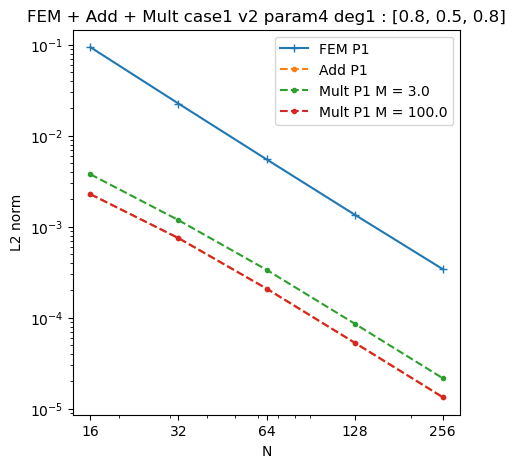

In [15]:
degree = 1
plot_Mult_vs_Add_vs_FEM(param_num,problem,degree,tab_M,result_dir=result_dir)

In [16]:
save_tab(param_num,problem,degree,tab_M,result_dir=result_dir)

/home/flecourtier/Bureau/Article1/code/src/modfenics/error_estimations/compare.py:129: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[error_cols] = df[error_cols].applymap(lambda x: f'{x:.2e}')
/home/flecourtier/Bureau/Article1/code/src/modfenics/error_estimations/compare.py:133: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[factor_cols] = df[factor_cols].applymap(lambda x: f'{int(round(x))}')
